# 3.2	Multi-component 1D counter-diffusion with reaction

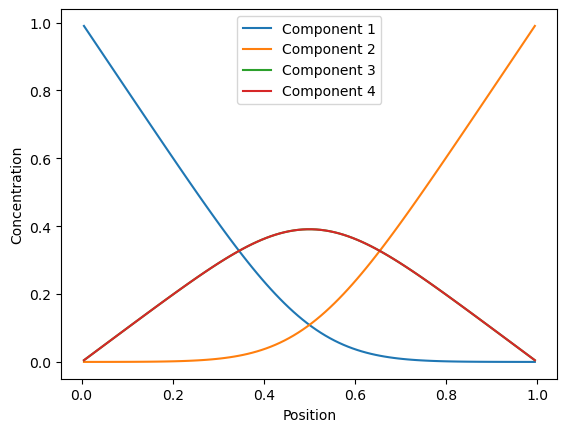

In [10]:
from pymrm import construct_grad, construct_div, numjac_local, newton
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import eye_array

num_c = 4
num_x = 100
L = 1
c = np.zeros((num_x, num_c))
D = 1
k = 500

def reaction(c):
    f = np.zeros_like(c)
    r = k * c[:, 0] * c[:, 1]
    f[:, 0] = -r
    f[:, 1] = -r
    f[:, 2] = r
    f[:, 3] = r
    return f

# Boundary conditions setup
bc = {'a': [0, 0], 'b': [1, 1], 'd':[ [[1, 0, 0, 0]], [[0, 1, 0, 0]]]}

# Grid setup
x_f = np.linspace(0, L, num_x+1)
x_c = 0.5*(x_f[:-1] + x_f[1:])

Grad, grad_bc = construct_grad(c.shape, x_f, x_c , bc, axis=0)
Div = construct_div(c.shape, x_f, nu=0, axis=0)

# Displacement Jacobian
Jac_diff = Div @ (D * Grad)
jac_diff_bc = Div @ (D * grad_bc)

def construct_jac(c):
    g_react, Jac_react = numjac_local(reaction, c, axis=1)
    Jac = Jac_diff + Jac_react
    g = Jac_diff @ c.reshape((-1,1)) + jac_diff_bc + g_react.reshape((-1,1))
    return g, Jac

result = newton(construct_jac, c)
c = result.x

plt.plot(x_c, c[:, 0], label='Component A')
plt.plot(x_c, c[:, 1], label='Component B')
plt.plot(x_c, c[:, 2], label='Component C')
plt.plot(x_c, c[:, 3], label='Component D')
plt.xlabel('Position')
plt.ylabel('Concentration')
plt.legend()
plt.show()



In [2]:
from pymrm import construct_grad, construct_div, numjac_local, newton
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import eye_array

class DiffusionReaction:
    def __init__(self, num_x):
        self.D = 1.0
        self.L = 1.0
        self.num_c = 4
        self.num_x = num_x
        self.bc = {'a': [0, 0], 'b': [1, 1], 'd':[ [[1, 0, 0, 0]], [[0, 1, 0, 0]]]}
        self.k = 1e6
        self.x_f = np.linspace(0,self.L,self.num_x+1)
        self.x_c = 0.5*(self.x_f[0:-1]+self.x_f[1:])
        self.init_field()
        self.init_Jac()

    def reaction(self, c):
        f = np.zeros_like(c)
        r = self.k * c[:, 0] * c[:, 1]
        f[:, 0] = -r
        f[:, 1] = -r
        f[:, 2] = r
        f[:, 3] = r
        return f
            
    def init_field(self, c0=0.0):
        self.c = np.full((self.num_x,self.num_c),c0, dtype='float')

    def init_Jac(self):
        Grad, grad_bc = construct_grad(self.c.shape, self.x_f, self.x_c, self.bc, axis=0)
        Div = construct_div(self.c.shape, self.x_f, axis=0)        
        Jac_diff = self.D * (Div @ Grad)
        f_diff_bc = self.D * (Div @ grad_bc)
        self.g_const = -f_diff_bc
        self.Jac_const = - Jac_diff
        
    def construct_Jac(self, c):
        g_react, Jac_react = numjac_local(self.reaction, c, axis=1)
        g = self.g_const + self.Jac_const @ c.reshape((-1,1)) - g_react.reshape((-1,1))
        Jac = self.Jac_const - Jac_react
        return g,Jac
        
    def solve(self):
        result = newton(self.construct_Jac, self.c, maxfev=10)
        self.c = result.x
        plt.plot(self.x_c, self.c[:, 0], label='Component A')
        plt.plot(self.x_c, self.c[:, 1], label='Component B')
        plt.plot(self.x_c, self.c[:, 2], label='Component C')
        plt.plot(self.x_c, self.c[:, 3], label='Component D')
        plt.xlabel('Position')
        plt.ylabel('Concentration')
        plt.legend()
        plt.show()

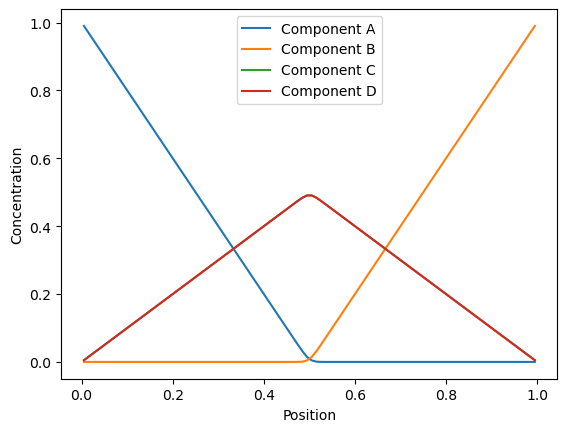

In [3]:
mrm_problem = DiffusionReaction(100)
mrm_problem.k = 1e6
mrm_problem.solve() 